In [1]:
# Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA


from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    StandardScaler
)

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV

import shap
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

C:\Users\17788\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Predicting Breast Cancer Diagnosis Using Cell Nuclei Morphology

This project will focus on building and assessing a machine-learning model that can determine the diagnosis (Malignant or Benign) based on the characteristics of cell nuclei. The dataset was obtained from the Diagnostic Wisconsin Breast Cancer Database and downloaded through Kaggle. The cell nuclei were observed using fine needle aspirate (FNA) of breast mass. 

The dataset includes features for radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry and fractal dimension. For each feature, the mean, standard error and worst/largest value were documented in separate columns. Malignant cell nuclei typically exhibit larger size and irregular shape, changes can also occur to the surface, volume, density, structure and homogeneity ([Link](https://www.ncbi.nlm.nih.gov/books/NBK9553/)). Previous findings have linked the identification of cell morphology to risk of metastasis and tumorigenicity ([Link](https://breast-cancer-research.biomedcentral.com/articles/10.1186/s13058-024-01796-8)) which facilitates widespread cancerous invasions to other organs such as bones, lungs, liver and brain ([Link](https://www.sciencedirect.com/science/article/pii/S1044579X1930063X#sec0010)).

This model will be trained on cell nuclei morphology to diagnose infections as malignant or benign using classification-supervised machine learning. It can be used as a tool to efficiently classify samples. It will also highlight the most important features that contribute to the diagnosis, thereby enhancing the interpretability of the output. 



### Load Dataset & Class Analysis

There are more cases with a benign diagnosis (62.74%) than malignant cases (37.26). The class imbalance is not severe, but is recognized as a limitation in this analysis: since there are more benign examples, the model created through this project may be more adapted to diagnosis begiegn cases than malignant. 

In [2]:
# Load in the Dataset
breast_cancer = pd.read_csv("data/breast-cancer-wisconsin.csv")
breast_cancer.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


Malignant Cases: 212, 37.26 %
Benign Cases: 357, 62.74 %


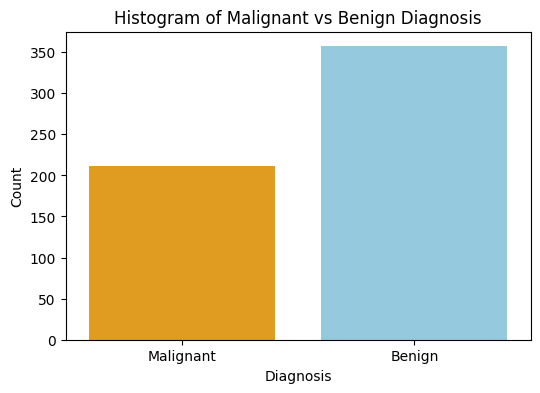

In [3]:
# Create a Histogram to show the Class Distribution
malignant_count = len(breast_cancer[breast_cancer["diagnosis"] == "M"])
benign_count = len(breast_cancer[breast_cancer["diagnosis"] == "B"])
print(f"Malignant Cases: {malignant_count}, {malignant_count/len(breast_cancer)*100:.2f} %")
print(f"Benign Cases: {benign_count}, {benign_count/len(breast_cancer)*100:.2f} %")

plt.figure(figsize=(6,4))
sns.countplot(x = 'diagnosis', 
              data=breast_cancer, 
              
              hue='diagnosis', 
              palette={'M': 'orange', 'B': 'skyblue'})
plt.title("Histogram of Malignant vs Benign Diagnosis")
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(ticks = ['M', 'B'], labels=['Malignant', 'Benign'])
plt.show()

### Exploratory Data Analysis (EDA)

- The dataset does not have any missing values (imputation not required).
- The **"ID"** and **"Unnamed: 32"** columns from the dataset are not useful, and will need to be removed. 
- Modify the diagnosis values into binary to make downstream analysis easier. 
- Split the data into train (70%) and test (30%) sets.

In [4]:
# Clean the Dataset (remove unneeded columns)
breast_cancer = breast_cancer.drop(columns = ["id", "Unnamed: 32"])

In [5]:
# Change the target column (diagnosis) into binary
breast_cancer['diagnosis'] = breast_cancer['diagnosis'].map({'M': 1, 'B': 0})

In [6]:
# Split the dataset into training and testing sets
train, test = train_test_split(breast_cancer, train_size = 0.7, random_state=123)
train

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
559,0,11.51,23.93,74.52,403.5,0.09261,0.10210,0.11120,0.04105,0.1388,...,12.48,37.16,82.28,474.2,0.12980,0.2517,0.36300,0.09653,0.2112,0.08732
295,0,13.77,13.27,88.06,582.7,0.09198,0.06221,0.01063,0.01917,0.1592,...,14.67,16.93,94.17,661.1,0.11700,0.1072,0.03732,0.05802,0.2823,0.06794
264,1,17.19,22.07,111.60,928.3,0.09726,0.08995,0.09061,0.06527,0.1867,...,21.58,29.33,140.50,1436.0,0.15580,0.2567,0.38890,0.19840,0.3216,0.07570
125,0,13.85,17.21,88.44,588.7,0.08785,0.06136,0.01420,0.01141,0.1614,...,15.49,23.58,100.30,725.9,0.11570,0.1350,0.08115,0.05104,0.2364,0.07182
280,1,19.16,26.60,126.20,1138.0,0.10200,0.14530,0.19210,0.09664,0.1902,...,23.72,35.90,159.80,1724.0,0.17820,0.3841,0.57540,0.18720,0.3258,0.09720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0,11.60,12.84,74.34,412.6,0.08983,0.07525,0.04196,0.03350,0.1620,...,13.06,17.16,82.96,512.5,0.14310,0.1851,0.19220,0.08449,0.2772,0.08756
322,0,12.86,13.32,82.82,504.8,0.11340,0.08834,0.03800,0.03400,0.1543,...,14.04,21.08,92.80,599.5,0.15470,0.2231,0.17910,0.11550,0.2382,0.08553
382,0,12.05,22.72,78.75,447.8,0.06935,0.10730,0.07943,0.02978,0.1203,...,12.57,28.71,87.36,488.4,0.08799,0.3214,0.29120,0.10920,0.2191,0.09349
365,1,20.44,21.78,133.80,1293.0,0.09150,0.11310,0.09799,0.07785,0.1618,...,24.31,26.37,161.20,1780.0,0.13270,0.2376,0.27020,0.17650,0.2609,0.06735


The dataset contains three perspectives for each feature (**mean, standard error and worst**). The PCA plot below compares a dataset with the mean features to the dataset containing all the features/perspectives. The dataset containing mean features reaches 100% cumalative variance with approximately 7 principal components, while the full dataset requires approximately 23 principal compoents to reach the same variance. This suggests that the additional perspectives are adding variance/dimensionality to the data, but it is not clear whether this will contribute to signal or noise. 

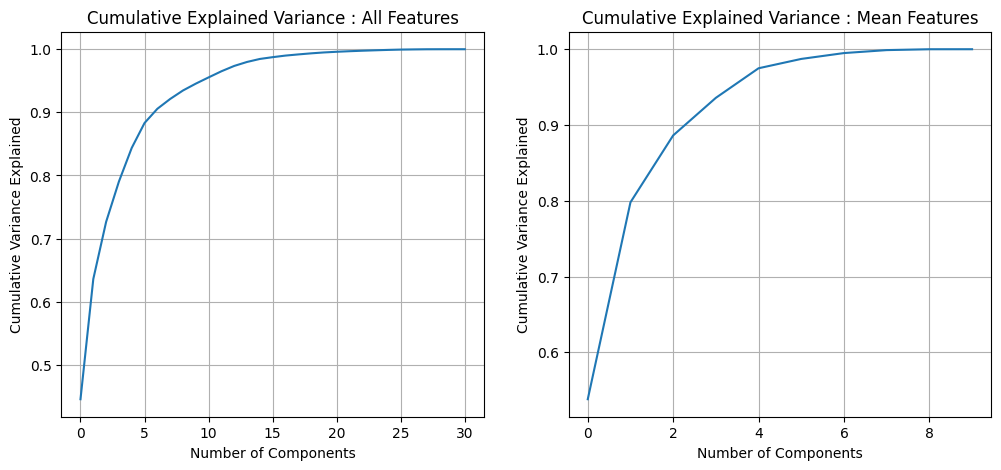

In [7]:
# Create PCA plots for training data
X_scaled = StandardScaler().fit_transform(train)
X_scaled_2 = StandardScaler().fit_transform(train.filter(like="_mean"))

fig, axes = plt.subplots(1,2, figsize=(12,5))

pca = PCA().fit(X_scaled)
pca_2 = PCA().fit(X_scaled_2)

axes[0].plot(pca.explained_variance_ratio_.cumsum())
axes[0].set_title("Cumulative Explained Variance : All Features")
axes[0].set_xlabel("Number of Components")
axes[0].set_ylabel("Cumulative Variance Explained")
axes[0].grid(True)


axes[1].plot(pca_2.explained_variance_ratio_.cumsum())
axes[1].set_title("Cumulative Explained Variance : Mean Features")
axes[1].set_xlabel("Number of Components")
axes[1].set_ylabel("Cumulative Variance Explained")
axes[1].grid(True)

plt.show()

Used the **describe** function to observe summary statistics on the columns showing the mean and worst values. The results indicate there is substantial variation between features, the dataset requires normalization. Standard deviation is consistently lower than the mean, suggesting variation is controlled. 

The heatmap indicates that features from different perspectives are not always correlated. However, features for the radius, perimeter and area (regardless of the perspective) are highly correlated (>0.9), these attributes are too similar and redundant to keep them all. Simularly, features for compactness, concavity, and concave points also have high correlation (>0.8), these attributes are also very simular. To avoid the risk of multicolinearity, we will filter for one the features in each of these groups.

In [8]:
# Show the summary statistics 
worst = train.filter(like="_worst").describe()
se = train.filter(like="_se").describe()
mean = train.filter(like="_mean").describe()
mean

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,14.144759,19.403593,92.078266,655.813065,0.095989,0.104524,0.089133,0.049081,0.181156,0.062798
std,3.496451,4.458139,24.040299,344.815080,0.013831,0.052519,0.080020,0.038360,0.028975,0.007392
min,7.691000,10.380000,47.920000,170.400000,0.052630,0.026500,0.000000,0.000000,0.106000,0.049960
25%,11.602500,16.187500,74.385000,412.525000,0.085977,0.066090,0.029950,0.020715,0.160300,0.057563
50%,13.515000,18.900000,87.295000,561.700000,0.095150,0.093020,0.062650,0.033455,0.178300,0.061400
75%,16.027500,21.892500,105.000000,796.650000,0.104575,0.129700,0.122400,0.073850,0.196000,0.066195
max,27.420000,39.280000,186.900000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,1.000000,0.741760,0.417916,0.753589,0.728190,0.311917,0.561086,0.659802,0.763253,0.311363,...,0.781348,0.460438,0.786728,0.740486,0.382813,0.568410,0.620282,0.784712,0.396055,0.269219
radius_mean,0.741760,1.000000,0.321228,0.997642,0.988027,0.154851,0.472330,0.635485,0.805707,0.147802,...,0.970950,0.311756,0.964931,0.938738,0.109862,0.404352,0.503270,0.738749,0.169952,-0.025435
texture_mean,0.417916,0.321228,1.000000,0.325717,0.323979,-0.060214,0.188772,0.278484,0.274815,0.006971,...,0.352484,0.918553,0.353893,0.347176,0.045281,0.237443,0.272022,0.266370,0.065520,0.068538
perimeter_mean,0.753589,0.997642,0.325717,1.000000,0.987225,0.192891,0.527183,0.678126,0.836756,0.184758,...,0.970909,0.316315,0.970836,0.939638,0.140098,0.449469,0.540973,0.767235,0.196560,0.020919
area_mean,0.728190,0.988027,0.323979,0.987225,1.000000,0.162563,0.472110,0.650498,0.811260,0.157053,...,0.970135,0.309187,0.965156,0.963261,0.117326,0.390984,0.499361,0.725206,0.159702,-0.020937
smoothness_mean,0.311917,0.154851,-0.060214,0.192891,0.162563,1.000000,0.663361,0.515249,0.548292,0.555035,...,0.191609,-0.001881,0.222275,0.189545,0.788360,0.484636,0.413794,0.490553,0.400218,0.495322
compactness_mean,0.561086,0.472330,0.188772,0.527183,0.472110,0.663361,1.000000,0.881399,0.825734,0.608899,...,0.500634,0.202011,0.561120,0.479286,0.550691,0.858430,0.786145,0.795554,0.504289,0.682482
concavity_mean,0.659802,0.635485,0.278484,0.678126,0.650498,0.515249,0.881399,1.000000,0.908753,0.516095,...,0.653125,0.283635,0.697811,0.644986,0.431785,0.764655,0.881115,0.851143,0.424301,0.523603
concave points_mean,0.763253,0.805707,0.274815,0.836756,0.811260,0.548292,0.825734,0.908753,1.000000,0.480018,...,0.813781,0.282891,0.842224,0.794244,0.440988,0.674024,0.734585,0.906049,0.395295,0.358454
symmetry_mean,0.311363,0.147802,0.006971,0.184758,0.157053,0.555035,0.608899,0.516095,0.480018,1.000000,...,0.179808,0.023787,0.215470,0.173947,0.407074,0.461088,0.419535,0.423153,0.713688,0.431712


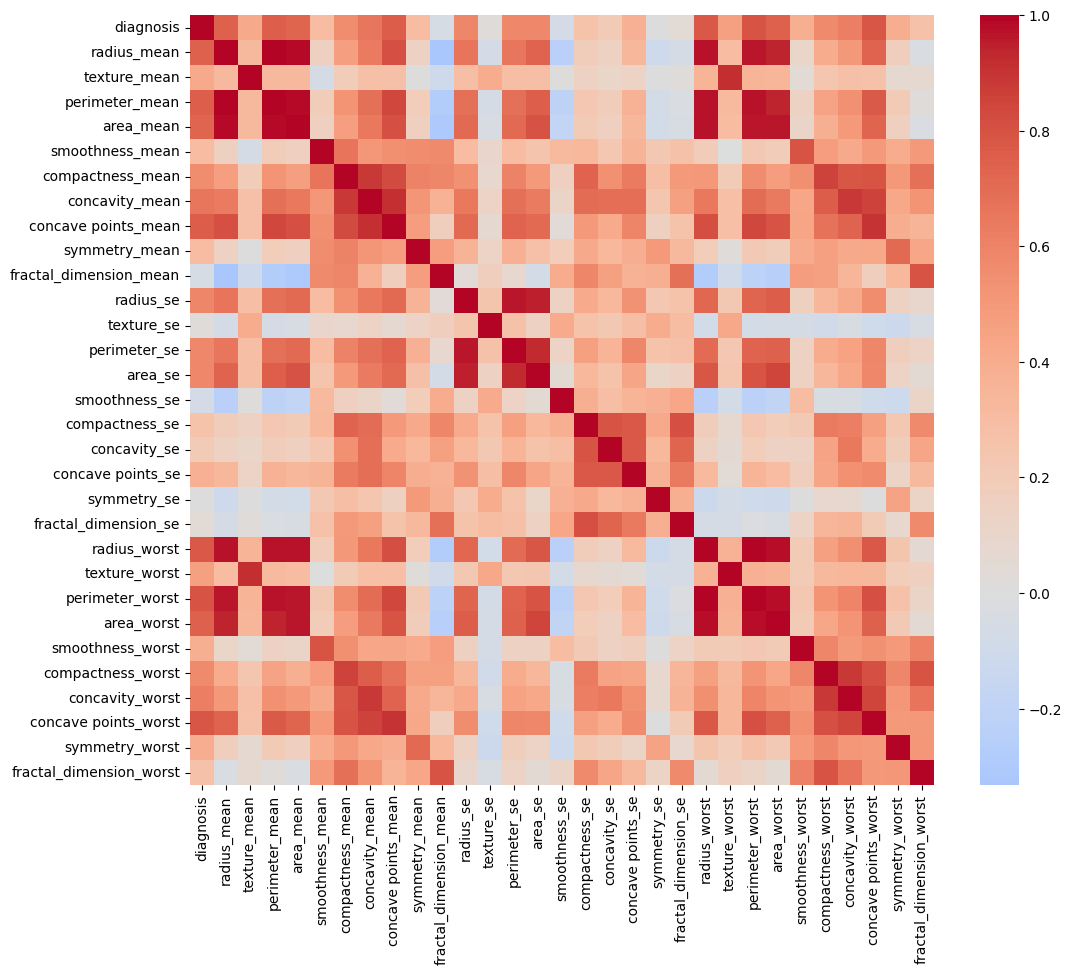

In [9]:
# Visualize a Heatmap of all the features
plt.figure(figsize=(12,10))
c = train.corr()
sns.heatmap(c,cmap="coolwarm",center=0)
c

Based on the correlation values between feature featuure and the target, the worst and mean values provide the largest associations with the diagnosis target feature. In particualr, **"perimeter"**, **"concave points"** and **"radius"** (all from the worst perspective) have the highest correspondance. In addition, the random forest classifier model was used to illustrate feature importance. The top features were **"area"**, **"radius"** and **"concave points"** (all from the worst perspective), while features from the standard error perspective were again rated lowly. Given these insights, the model will be filtered to contain only the worst and mean features. To address the correlations observed in the heatmap above, the dataset will be removed of values in **"radius"** and **"perimeter"** but will maintain **"area"** (the feature with the highest feature importance). For the same reasons, the feature for **"concave points"** will be kept in the dataset while **"concavity"** and **"compactness"** will be removed. 

In [10]:
# Calculate the correlation between each feature and the target
X_train_corr = train.copy()
pd.DataFrame(X_train_corr.corr()['diagnosis'].sort_values(ascending=False))

,diagnosis
diagnosis,1.000000
perimeter_worst,0.786728
concave points_worst,0.784712
radius_worst,0.781348
concave points_mean,0.763253
perimeter_mean,0.753589
radius_mean,0.741760
area_worst,0.740486
area_mean,0.728190
concavity_mean,0.659802


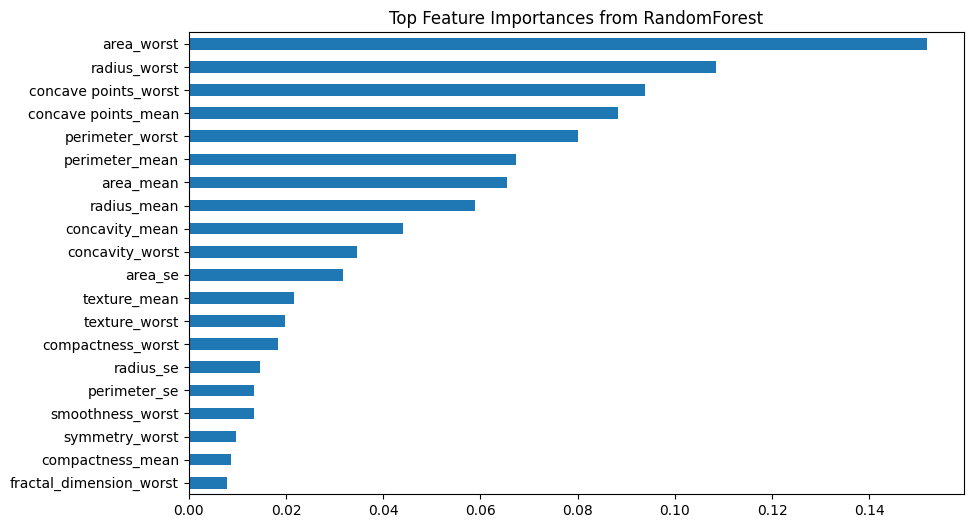

In [11]:
# Use RandomForest to obtain feature importance
x = train.drop(columns = "diagnosis")
y= train["diagnosis"]
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x, y)

importances = pd.Series(rf.feature_importances_, index=x.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.head(20).plot(kind='barh')
plt.title('Top Feature Importances from RandomForest')
plt.gca().invert_yaxis()
plt.show()

### Feature Engineering

- Filter for features with _mean and _worst
- Remove features : perimeter, concavity, radius, compactness

In [12]:
# Filter training dataset (extract specific feature columns)
train_mean = train.filter(like = "_mean")
train_diagnosis = train["diagnosis"]
train_worst = train.filter(like = "_worst")

train_combined = pd.concat([train_mean, train_worst], axis=1)
train_combined["diagnosis"] = train["diagnosis"]

In [13]:
# Filter training and testing dataset (remove specific feature columns)
cols_to_drop = train_combined.filter(like="perimeter_").columns.tolist()
cols_to_drop += train_combined.filter(like="concavity_").columns.tolist()
cols_to_drop += train_combined.filter(like="radius_").columns.tolist()
cols_to_drop += train_combined.filter(like="compactness_").columns.tolist()

train_filtered = train_combined.drop(columns = cols_to_drop)
test_filtered = test[train_filtered.columns]

### Preprocessing and Transformations

First, separate the dataset into the features used to obtain the target (X) and the actual target column (y), this will be done on test and training datasets. Create a preprocessor that will normalize the data columns so that they are comparable. 

Added a function that retrieves the mean values of scoring data (scoring method = recall), which will make it easier to format the results in downstream analsysi of models. Note that this code was adapted form CPSC 330, University of British Columbia (UBC), (2024).

In [14]:
# Separate target data (y) and the rest of the features (X)
X_train = train_filtered.drop(columns=['diagnosis'])
y_train = train_filtered['diagnosis']

X_test = test_filtered.drop(columns=['diagnosis'])
y_test = test_filtered['diagnosis']

In [15]:
# Dict to store results
results = {}

In [16]:
# Create Preprocessor to standardize data
preprocessor = make_column_transformer(
    (StandardScaler(), X_train.columns),
    remainder='passthrough' 
)

In [17]:
# Function to calculate the mean values of score data
def mean_std_cross_val_scores(model, X_train, y_train, scoring = 'recall', cv = 10, **kwargs):

    '''Input model, training features (X) and target features (y)'''
    '''Calculates mean and std of each score (recall)'''
    '''Outputs a series containing these results'''

    scores = cross_validate(model, X_train, y_train, 
                   return_train_score= True, scoring = scoring, cv = cv,
                   **kwargs)
    
    scores_mean = pd.DataFrame(scores).mean()
    scores_std = pd.DataFrame(scores).std()
    output = []

    for n in range(len(scores_mean)):
        output.append(f"{scores_mean.iloc[n]:.2f} +/- {scores_std.iloc[n]:.2f}")

    return pd.Series(data = output, index = scores_mean.index)
    
# Adapted code form CPSC 330, University of British Columbia (UBC), (2024)

### Baseline Model

The baseline model using the DummyClassifier resulted in a test score and train score of 0.00 +/- 0.00, showing that the minimal threshold for future models should atleast be above zero. 

In [18]:
# Create and test Dummy model
dummy_pipe = make_pipeline(preprocessor, DummyClassifier(strategy = "most_frequent"))
score = mean_std_cross_val_scores(dummy_pipe, X_train, y_train)

In [19]:
# Visualize results of Dummy model
results["Dummy Classifier"] = score
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy Classifier,0.00 +/- 0.01,0.00 +/- 0.00,0.00 +/- 0.00,0.00 +/- 0.00


### Linear Model

The dataset was tested on a linear model, Logistic Regression with hyperparamter tuning of "C". All the results showed no signs of overfitting (based on the training scores), and the majority of test scores demonstrated high recall. In particular when C = 100, the test score was 96.5% (the training score was around the same, at 96.6%). Overall, larger C values are showing the largest test scores. The linear model performs significantly better than the baseline.

In [20]:
# Create dict to hold the results, and the C hyperparamete values
lr_scores_dict = {
    "C" : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "mean_train_scores" : list(),
    "mean_cv_scores" : list()
}

In [21]:
#** change to mean_std_cross_val_scores and add to the main results table
for C in lr_scores_dict["C"]:
    lr = LogisticRegression(C=C, max_iter=1000)
    pipe_lr = make_pipeline(preprocessor, lr)
    score = mean_std_cross_val_scores(pipe_lr, X_train, y_train)
    
    lr_scores_dict["mean_train_scores"].append(score["train_score"])
    lr_scores_dict["mean_cv_scores"].append(score["test_score"])

In [22]:
pd.DataFrame(lr_scores_dict)

,C,mean_train_scores,mean_cv_scores
0,0.001,0.42 +/- 0.02,0.42 +/- 0.11
1,0.010,0.83 +/- 0.01,0.82 +/- 0.09
2,0.100,0.94 +/- 0.01,0.94 +/- 0.06
3,1.000,0.95 +/- 0.01,0.95 +/- 0.06
4,10.000,0.96 +/- 0.01,0.94 +/- 0.06
5,100.000,0.97 +/- 0.01,0.97 +/- 0.06
6,1000.000,0.96 +/- 0.00,0.96 +/- 0.06


In [28]:
lr_scores_dict

{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'mean_train_scores': ['0.42 +/- 0.02',
  '0.83 +/- 0.01',
  '0.94 +/- 0.01',
  '0.95 +/- 0.01',
  '0.96 +/- 0.01',
  '0.97 +/- 0.01',
  '0.96 +/- 0.00'],
 'mean_cv_scores': ['0.42 +/- 0.11',
  '0.82 +/- 0.09',
  '0.94 +/- 0.06',
  '0.95 +/- 0.06',
  '0.94 +/- 0.06',
  '0.97 +/- 0.06',
  '0.96 +/- 0.06']}

In [23]:
# add to the main results table
results["Logistic Regression (C=100)"] = lr_scores_dict.get("C", 100)

In [26]:
results

{'Dummy Classifier': fit_time       0.00 +/- 0.01
 score_time     0.00 +/- 0.00
 test_score     0.00 +/- 0.00
 train_score    0.00 +/- 0.00
 dtype: object,
 'Logistic Regression (C=100)': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

### Additional Models

Some additional models that were trained on the dataset are gradient boosting, catboost and SVM RBF. It is important to note these tests were performed without hyperparameter optimization, to retrieve basline data on how well the models learn from the data. The Gradient Boosting model overfitted on the data (training score = 100%). The Catboost (test score = 93%, train score = 97%) and SVM RBF (test score = 88%, train score = 92%) models contained better results, however the training score was still high. Of all the tested models (without hyperparameter optimization), Catboost reported the best test results.  

In [ ]:
# maybe try without the gamme thing

models = {
    "Gradient Boosting" : GradientBoostingClassifier(random_state=123),
    #"Random Forest" : RandomForestClassifier(n_jobs=-1, random_state=123),
    "Catboost" : CatBoostClassifier(random_state=123, verbose=0, iterations=100),
    "SVM RBF" : SVC(gamma = 0.01)
}

In [27]:
for m in models : 
    new_pipe = make_pipeline(preprocessor, models[m])
    score = mean_std_cross_val_scores(new_pipe, X_train, y_train, 
                           scoring = 'recall', 
                           cv=10)
    
    results[f"{m}"] = score

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy Classifier,0.00 +/- 0.00,0.00 +/- 0.00,0.00 +/- 0.00,0.00 +/- 0.00
Gradient Boosting,0.22 +/- 0.01,0.00 +/- 0.00,0.94 +/- 0.06,1.00 +/- 0.00
Random Forest,0.14 +/- 0.03,0.02 +/- 0.00,0.93 +/- 0.05,1.00 +/- 0.00
Catboost,0.17 +/- 0.04,0.01 +/- 0.00,0.93 +/- 0.06,0.97 +/- 0.01
SVM RBF,0.01 +/- 0.00,0.00 +/- 0.00,0.88 +/- 0.08,0.92 +/- 0.01


### Feature Selection

Used Recursive Feature Elimination with Cross-Validation (RFECV) to determine feature importance with the linear model, Logistic regression. As a result, the RFECV technique determined that x and x should be eliminated and will not contribute significantly to the target output. In contrast, x, x and x were selected as part of the best performing subset. The RFECV model was integrated into the pipeline to test feature selection with logistic regression, and the result was sub-optimal. The test ...


In [ ]:
rfe_cv = RFECV(LogisticRegression(max_iter=2000), cv=10)
rfe_cv_pipe = make_pipeline(preprocessor, rfe_cv)
rfe_cv_pipe.fit(X_train, y_train)

#print(rfe_cv.support_)
feature_names = preprocessor.get_feature_names_out()
#print(feature_names[rfe_cv.support_])

ranking_df = pd.DataFrame({
    'feature': feature_names,
    'rank': rfe_cv.ranking_,
    'selected': rfe_cv.support_
})

ranking_df

[ True  True  True  True False  True  True  True  True  True  True False]
['standardscaler__texture_mean' 'standardscaler__area_mean'
 'standardscaler__smoothness_mean' 'standardscaler__concave points_mean'
 'standardscaler__fractal_dimension_mean' 'standardscaler__texture_worst'
 'standardscaler__area_worst' 'standardscaler__smoothness_worst'
 'standardscaler__concave points_worst' 'standardscaler__symmetry_worst']


In [ ]:
# should do this with catboost too? 
# maybe should just use logistic regression here acturally

rfe_lr_pipe = make_pipeline(preprocessor, 
                            rfe_cv,
                            SVC(gamma = 0.01))

score = mean_std_cross_val_scores(rfe_lr_pipe, X_train, y_train, scoring = 'recall', cv=10)

results["RFECV + SVM RBF"] = score

In [30]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy Classifier,0.00 +/- 0.00,0.00 +/- 0.00,0.00 +/- 0.00,0.00 +/- 0.00
Gradient Boosting,0.22 +/- 0.01,0.00 +/- 0.00,0.94 +/- 0.06,1.00 +/- 0.00
Random Forest,0.14 +/- 0.03,0.02 +/- 0.00,0.93 +/- 0.05,1.00 +/- 0.00
Catboost,0.17 +/- 0.04,0.01 +/- 0.00,0.93 +/- 0.06,0.97 +/- 0.01
SVM RBF,0.01 +/- 0.00,0.00 +/- 0.00,0.88 +/- 0.08,0.92 +/- 0.01
RFECV + SVM RBF,0.35 +/- 0.01,0.00 +/- 0.00,0.89 +/- 0.07,0.91 +/- 0.02


### Hyperparameter Optimization

Performed hyperparameter optimization on the best models (not logistic regression because it was tuned previously). For SVM RBF, tested the "C" and "gamma" hyperparameters, while for catboost tested "learning rate" and "depth". Both models showed notable improvements after tuning. Catboost performed the best at a learning rate of 0.1, depth of 6-7 and 100 iterations, showing a 94% recall on the test set and 98% on the training set. There were minimal improvments while the depth increased from 8-10 under the same conditions, but the training score increased more quickly and risks overfitting. For the SVM RBF model, the best results were retireved with C was 1000 and gamma 0.001, which resulted in 96% recall for both the training and testing scores. The results of the SVM RBF model are now comparable to the linear model with logistic regression, only slightly lower. Note that SVM RBF improved more greatly than catboost due to hyperparamter optimization. 

In [ ]:
svm_param_optimize_dic = {
    "C" : [0.01, 0.1, 1, 10, 100, 1000],
    "gamma" : [1e-4, 1e-3, 1e-2, 1e-1, 1],
    "kernel" : ["rbf"]
}

catboost_param_optimize_dic = {
    "learning_rate": [0.01, 0.1],
    "iterations": [100],
    "depth": list(range(4, 11)),
}

In [37]:
cb_results = []

for lr in catboost_param_optimize_dic["learning_rate"] : 
    for it in catboost_param_optimize_dic["iterations"] : 
        for dep in catboost_param_optimize_dic["depth"] : 
            
            model = CatBoostClassifier(learning_rate = lr, iterations = it, depth = dep, verbose = 0)
            pipe = make_pipeline(preprocessor, model)
            score = mean_std_cross_val_scores(pipe, X_train, y_train, scoring = 'recall', cv=10)

            cb_results.append({
                "learning_rate" : lr, 
                "iterations" : it, 
                "depth" : dep, 
                "cv_score_mean" : score["test_score"],
                "train_score_mean" : score["train_score"]
            }) 

In [ ]:
pd.DataFrame(cb_results)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
learning_rate,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,0.1,0.1,0.1
iterations,100,100,100,100,100,100,100,100,100,100,100,100,100,100
depth,4,5,6,7,8,9,10,4,5,6,7,8,9,10
cv_score_mean,0.92 +/- 0.05,0.92 +/- 0.05,0.92 +/- 0.05,0.93 +/- 0.06,0.92 +/- 0.05,0.93 +/- 0.06,0.92 +/- 0.06,0.94 +/- 0.06,0.92 +/- 0.07,0.94 +/- 0.06,0.94 +/- 0.06,0.94 +/- 0.06,0.94 +/- 0.05,0.94 +/- 0.05
train_score_mean,0.93 +/- 0.01,0.93 +/- 0.01,0.94 +/- 0.01,0.95 +/- 0.01,0.94 +/- 0.01,0.95 +/- 0.01,0.96 +/- 0.01,0.97 +/- 0.01,0.97 +/- 0.01,0.98 +/- 0.01,0.98 +/- 0.01,0.99 +/- 0.01,0.99 +/- 0.00,1.00 +/- 0.00


In [46]:
svm_results = []

for c in svm_param_optimize_dic["C"] : 
    for g in svm_param_optimize_dic["gamma"] : 
        for k in svm_param_optimize_dic["kernel"] : 
            
            model = SVC(C = c, gamma = g, kernel = k)
            pipe = make_pipeline(preprocessor, model)
            score = mean_std_cross_val_scores(pipe, X_train, y_train, scoring = 'recall', cv=10)

            svm_results.append({
                "C" : c, 
                "gamma" : g, 
                "cv_score_mean" : score["test_score"],
                "train_score_mean" : score["train_score"]
            }) 

In [ ]:
pd.DataFrame(svm_results)

,C,gamma,cv_score_mean,train_score_mean
0,0.01,0.0001,0.00 +/- 0.00,0.00 +/- 0.00
1,0.01,0.0010,0.00 +/- 0.00,0.00 +/- 0.00
2,0.01,0.0100,0.00 +/- 0.00,0.00 +/- 0.00
3,0.01,0.1000,0.00 +/- 0.00,0.00 +/- 0.00
4,0.01,1.0000,0.00 +/- 0.00,0.00 +/- 0.00
5,0.10,0.0001,0.00 +/- 0.00,0.00 +/- 0.00
6,0.10,0.0010,0.00 +/- 0.00,0.00 +/- 0.00
7,0.10,0.0100,0.76 +/- 0.10,0.77 +/- 0.01
8,0.10,0.1000,0.87 +/- 0.09,0.88 +/- 0.01
9,0.10,1.0000,0.00 +/- 0.00,0.00 +/- 0.00


### Interpretation and Feature Importances



In [55]:
X_train_enc = pd.DataFrame(
    data = preprocessor.transform(X_train),
    columns = feature_names,
    index = X_train.index
)

X_test_enc = pd.DataFrame(
    data = preprocessor.transform(X_test),
    columns = feature_names,
    index = X_test.index
)

In [57]:
best_lr_model = LogisticRegression(C = 100)
best_lr_model.fit(X_train_enc, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,100
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [ ]:
explainer = shap.LinearExplainer(best_lr_model, X_train_enc)
train_shap_values = explainer.shap_values(X_train_enc)
test_shap_values = explainer.shap_values(X_test_enc)

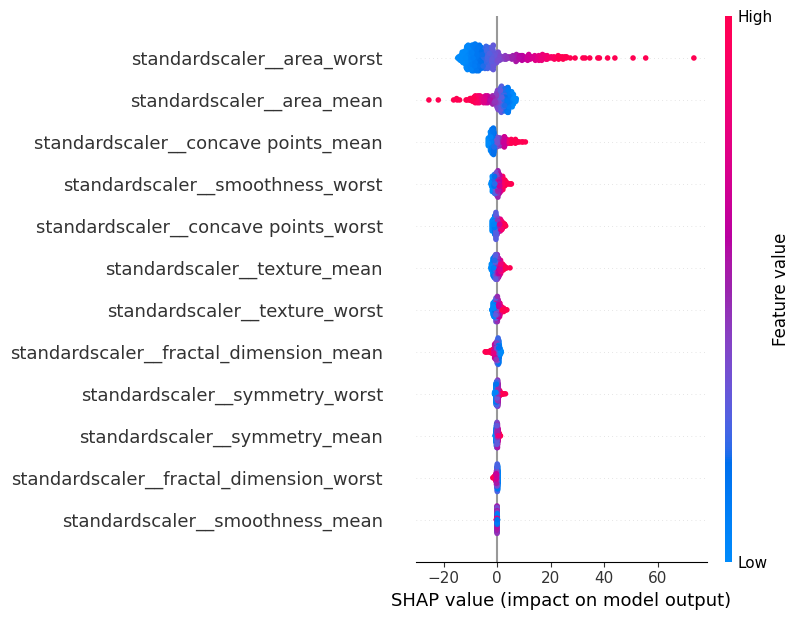

In [61]:
shap.summary_plot(train_shap_values, X_train_enc)

### Results on Test Set

In [ ]:
test_pred = best_lr_model.predict(X_test_enc)
test_score = recall_score(y_test, test_pred)

test_score

0.9852941176470589

In [ ]:
cm = confusion_matrix(y_test, test_pred)
cm

array([[103,   0],
       [  1,  67]])

### Results Summary

In [ ]:
results

### Takeaways
-
-
-